In [3]:
from astropy.io import fits
from scipy.signal import fftconvolve
import numpy as np
import seaborn as sns
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

In [5]:
sns.set(rc={'figure.figsize': (50, 50)})
%matplotlib inline

In [6]:
test_set = "/scratch/datasets/astro_deconv_2019/test/"
indexes=list(range(5000, 105000, 5000))

In [7]:
test_start = 9400
test_end = 9700

In [8]:
def open_fits(x):
    return fits.open(x)[0].data.squeeze()

def convolve(convoled, convolver):
    p = convolver.shape[0]
    r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
    return fftconvolve(convoled, convolver, mode="full")[r,r]

In [9]:
# calculate wsclean baseline
l1_wsclean = []
for number in range(test_start, test_end):
    target_path = "{}{}-skymodel.fits".format(test_set, number)
    wsclean_model_path = "{}{}-wsclean-model.fits".format(test_set, number)
    clean_beam_path = "{}{}-clean-beam.fits".format(test_set, number)
    clean_beam = open_fits(clean_beam_path)
    target = open_fits(target_path)
    wsclean_model = open_fits(wsclean_model_path)
    target_convolved = convolve(target, clean_beam)
    wsclean_convoled = convolve(wsclean_model, clean_beam)
    l1_wsclean.append(np.sum(np.abs( wsclean_model - target)))

In [10]:
wsclean_scaling = 1 / np.average(l1_wsclean)

In [11]:
def compute(neural_output, start, end):
    scores = []
    for number in range(start, end):
        target_path = "{}{}-skymodel.fits".format(test_set, number)
        neural_model_path = "{}{}-outputs.fits".format(neural_output, number)
        clean_beam_path = "{}{}-clean-beam.fits".format(test_set, number)
        clean_beam = open_fits(clean_beam_path)
        target = open_fits(target_path)
        neural_model = open_fits(neural_model_path )
        target_convoled = convolve(target, clean_beam)
        neural_convolved = convolve(neural_model, clean_beam)
        score = np.sum(np.abs( neural_convolved - target_convoled))
        scores.append(score)
    return scores

In [2]:
def doit(wsclean_scaling, type_, run, index):
    print(f"type: {type_} run: {run} index: {index}")
    neural_output = f"/scratch/vacuum-cleaner/final_eval_lr/{type_}/test/run{run}/{index}/fits/"
    scores = compute(neural_output, test_start, test_end)
    #scaled = np.average(scores) * wsclean_scaling
    return scores
 
num_cores = multiprocessing.cpu_count()

NameError: name 'multiprocessing' is not defined

In [14]:
scores = {}

In [43]:
for type_ in ("gan_psf_res",): #, "gan_psf", "gan_psf_res"):
    for run in range(1, 11):
        p = Parallel(n_jobs=num_cores)
        steps = p(delayed(doit)(wsclean_scaling, type_, run, index) for index in indexes)
        scores[f"{type_}__run{run}"] = steps

In [44]:
data = pd.DataFrame(scores, index=indexes)

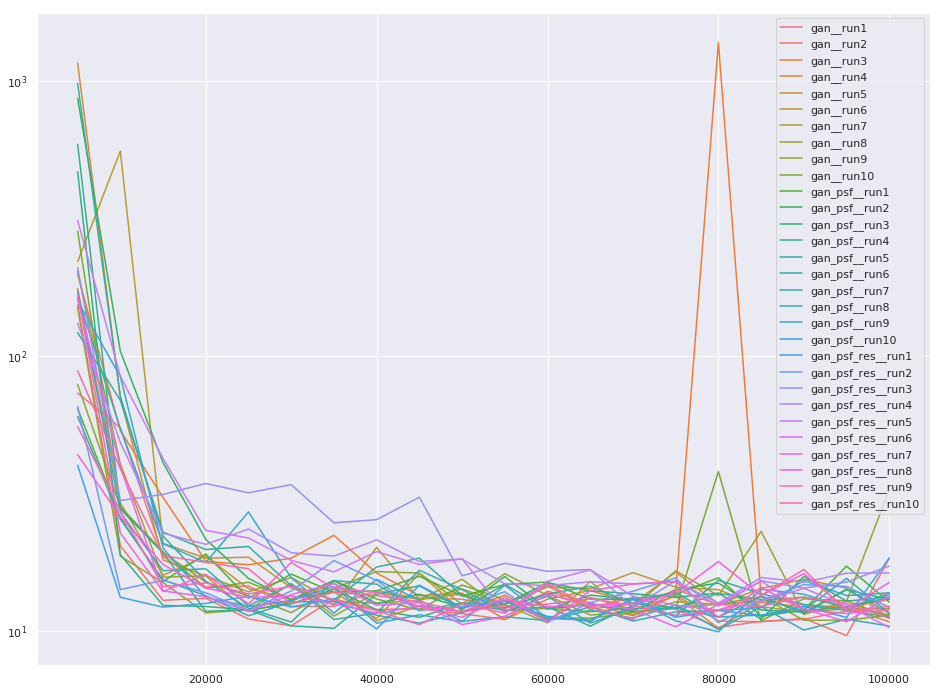

In [45]:
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data, dashes=False)
p.set_yscale('log')

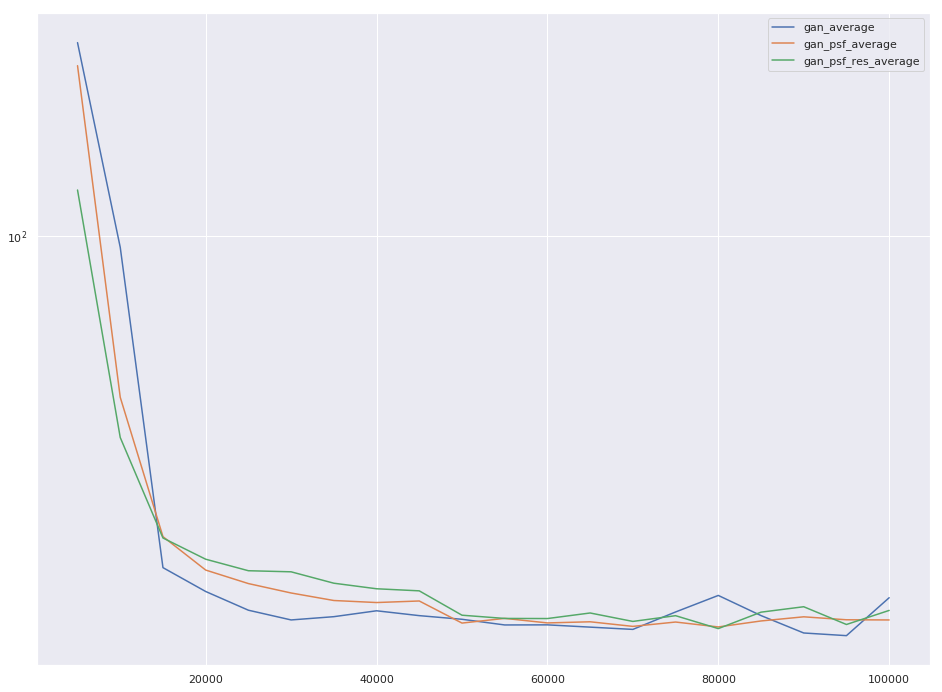

In [46]:
plt.figure(figsize=(16, 12))
avg_data = pd.DataFrame({
    'gan_average': data.drop('gan__run3', axis=1).filter(regex='gan__').mean(axis=1),
    'gan_psf_average': data.filter(regex='gan_psf_').mean(axis=1),
    'gan_psf_res_average': data.filter(regex='gan_psf_res_').mean(axis=1),
})
p = sns.lineplot(data=avg_data, dashes=False)
p.set_yscale('log')

In [35]:
data.mean().sort_values()

gan_psf__run8     14.906196
gan_psf__run1     17.436588
gan__run9         17.481530
gan__run1         18.073270
gan__run2         19.672784
gan__run8         21.661017
gan_psf__run7     21.731342
gan__run5         22.767669
gan_psf__run5     22.944240
gan_psf__run10    23.614898
gan_psf__run9     23.671547
gan__run7         24.094966
gan__run10        28.716340
gan_psf__run3     36.056788
gan_psf__run4     42.488619
gan__run6         52.123612
gan_psf__run2     62.352531
gan_psf__run6     64.485480
gan__run4         73.105268
gan__run3         94.851826
dtype: float64

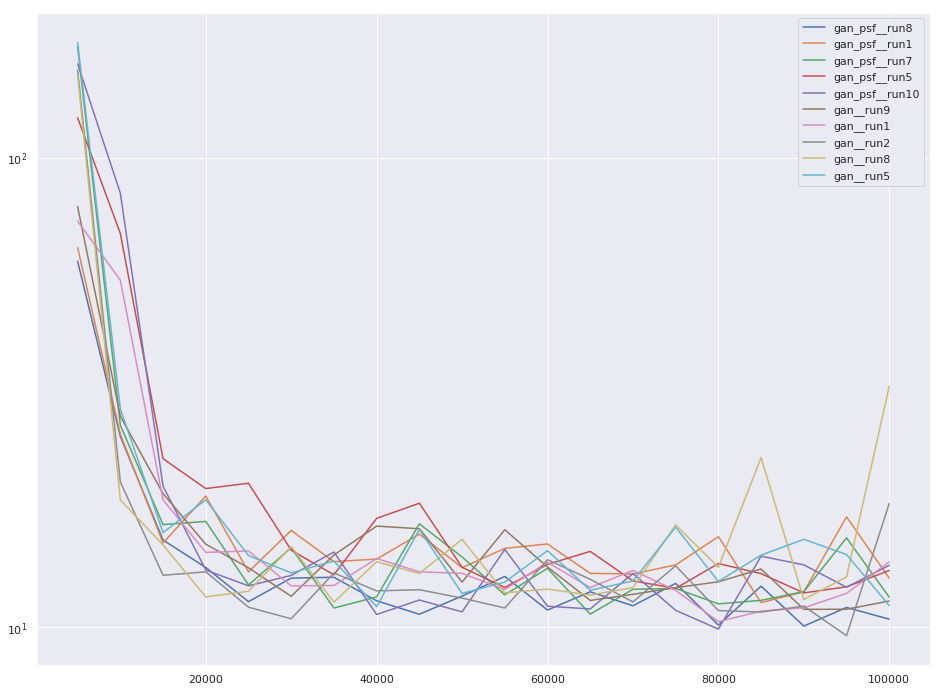

In [36]:
selection = ["gan_psf__run8", "gan_psf__run1", "gan_psf__run7", "gan_psf__run5", "gan_psf__run10",
             "gan__run9", "gan__run1", "gan__run2", "gan__run8", "gan__run5"]
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data[selection], dashes=False)
p.set_yscale('log')

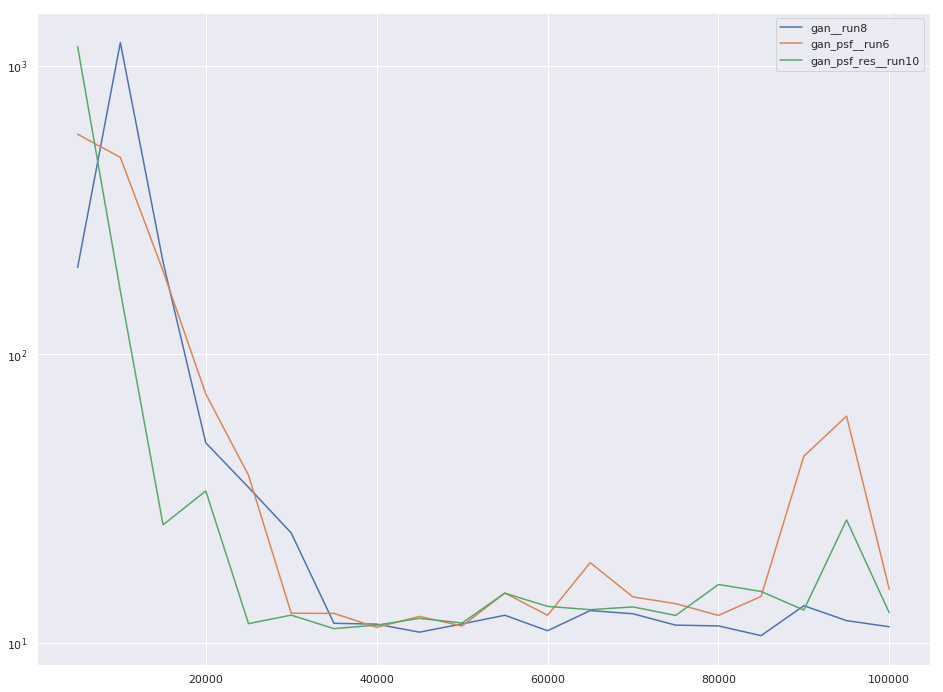

In [74]:
selection = ["gan__run8", "gan_psf__run6", "gan_psf_res__run10"]
plt.figure(figsize=(16, 12))
p = sns.lineplot(data=data[selection], dashes=False)
p.set_yscale('log')